- On utilise un réseau Unet pour la segmentation d'images sous marines            
- On utilise la librairie Fastai basée sur pytorch, elle incorpore plusieurs fonctions déja construites
- le réseau est préentrainé sur imagenet et on entraine les dernières couches sur le dataset: suim_dataset
- article: Semantic Segmentation of Underwater Imagery: Dataset and Benchmark
- source dataset: Source: https://irvlab.cs.umn.edu/resources/usr-248-dataset
- paper: https://arxiv.org/pdf/2004.01241.pdf

RGB color code and object categories

- 000 BW: Background waterbody                    (black)---0
- 001 HD: Human divers                            (blue)----1
- 010 PF: Plants/sea-grass                        (green)---2
- 011 WR: Wrecks/ruins                            (cyan)----3
- 100 RO: Robots/instruments                      (red)-----4
- 101 RI: Reefs and invertebrates                 (Pink)----5
- 110 FV: Fish and vertebrates                    (yellow)--6
- 111 SR: Sand/sea-floor (& rocks)                (white)---7

In [1]:
from fastai.vision.all import *

In [2]:
path_data = Path("/mnt/narval/narval_BL/narval_datasets/suim-datasets/train_val/")
path_img = path_data/"images/"
path_lbl = path_data/"masks_png/"
path_test = Path("/mnt/narval/narval_BL/narval_datasets/suim-datasets/TEST/")

In [3]:
# on compte le nombre d'image et de masques
import collections

number_images = collections.Counter(p.suffix for p in path_img.iterdir())
number_mask = collections.Counter(p.suffix for p in path_lbl.iterdir())
print(f'# images: {number_images}, # mask: {number_mask}')

# images: Counter({'.jpg': 1525}), # mask: Counter({'.png': 1525})


In [4]:
 # données

fnames = get_image_files(path_img)            # images
lbl_names = get_image_files(path_lbl)         # mask
print(fnames[0:3])                           
print(lbl_names[0:3])

[Path('/mnt/narval/narval_BL/narval_datasets/suim-datasets/train_val/images/d_r_440_.jpg'), Path('/mnt/narval/narval_BL/narval_datasets/suim-datasets/train_val/images/f_r_1853_.jpg'), Path('/mnt/narval/narval_BL/narval_datasets/suim-datasets/train_val/images/d_r_428_.jpg')]
[Path('/mnt/narval/narval_BL/narval_datasets/suim-datasets/train_val/masks_png/w_r_29_P.png'), Path('/mnt/narval/narval_BL/narval_datasets/suim-datasets/train_val/masks_png/d_r_211_P.png'), Path('/mnt/narval/narval_BL/narval_datasets/suim-datasets/train_val/masks_png/f_r_1130_P.png')]


In [7]:
 # format d'une image (RGB) et d'un mask

img_f = fnames[0]
print(type(img_f))
img = PILImage.create(img_f)
print(f'image shape:\n{tensor(img).shape}')

# fonction pour trouver le mask associé
get_y_fn = lambda x: path_lbl/f'{x.stem}P.png'

mask_f = get_y_fn(img_f)
mask = PILMask.create(mask_f)
print(f'mask shape:\n{mask.shape}')

<class 'pathlib.PosixPath'>
image shape:
torch.Size([480, 640, 3])
mask shape:
(480, 640)


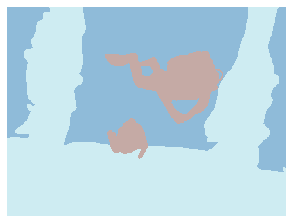

In [8]:
mask.show()

In [9]:
# un masque
src = tensor(mask)
print(src.unique())
print(src)

tensor([0, 1, 2], dtype=torch.uint8)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2]], dtype=torch.uint8)


In [8]:
 # on prend une série d'images avec les masques associés

n1, n2 = 0, 10
images_files = [fnames[n1+i] for i in range(n1+n2)]
masks_files = list(map(get_y_fn,images_files))

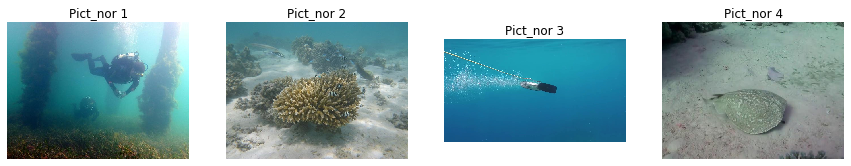

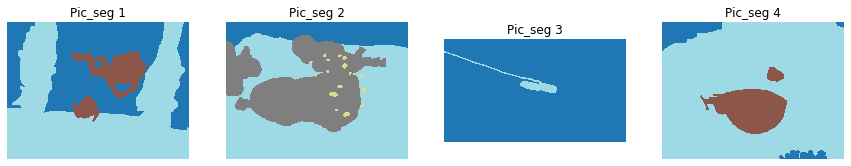

In [11]:
 # plot d'images et masques associés

_,axs = plt.subplots(1,4,figsize=(15,15))
for i,ax in enumerate(axs): 
    img_f = fnames[i]
    img = PILImage.create(img_f)
    img.show(ax=ax, title=f'Pict_nor {i+1}')

_,axs = plt.subplots(1,4,figsize=(15,15))
for i,ax in enumerate(axs): 
    img_f = fnames[i]
    mask = PILMask.create(get_y_fn(img_f))
    mask.show(ax=ax, title=f'Pic_seg {i+1}', alpha=1) 

In [5]:
 # codes masks
# bw: Background waterbody
# hd: Human divers
# pf: auquatic plants/sea grass
# wr: wrecks/ruins
# ro: robots/instruments
# ri: reefs/invertebrates
# fv: fish and vertebrates
# sr: sand/ sea floor and rocks

codes = ['background', 'human_diver', 'aquatic_plants', 'wreck_ruins',
          'robots_instruments', 'reefs_invertebrates', 'fish_vertebrates',
         'sand_sea_floor_rocks']

codes = np.array(codes, dtype = str)
print(f'number of classes labels:{len(codes)}')

number of classes labels:8


In [6]:
# cette function permet d'extraire le mask associée à l'image correspondante
def label_func(fn): return path_data/'masks_png'/f'{fn.stem}P.png'

test1 = label_func(fnames[0])
print(fnames[0])
print(test1)

/mnt/narval/narval_BL/narval_datasets/suim-datasets/train_val/images/d_r_440_.jpg
/mnt/narval/narval_BL/narval_datasets/suim-datasets/train_val/masks_png/d_r_440_P.png


In [7]:
 # Datablock - Dataloader - class définit par fastai

# on définit un datablock en répondant aux questions suivantes:
# 1. type d'entrées et cibles: Images et mask
# 2. Ou sont les images: dans les répertoires
# 3. séparation train et valid set: random split (80 % pour le train et 20 % pour le validation set)
# 4. comment trouver le label associé à une image: en regardant le fichier correspondant dans le répertoire maskpng
# 5. après que le batch soit crée on applique data augmentation

def get_dls(bs, size,codes):
    data_img = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),  
                   get_items=get_image_files,                               # sources                          
                   splitter = RandomSplitter(seed=42),                      # split train/valid
                   get_y= label_func,                                       # associated y target (dependant variable)
                   item_tfms=Resize(size),                                   
                   batch_tfms=[*aug_transforms(size=size), Normalize.from_stats(*imagenet_stats)]) 
                                                                            # series de transformations et normalisation
    #print(data_img.summary(path_data/'images'))
    
    return data_img.dataloaders(path_data/"images", bs=bs)

In [8]:
bs = 8                            # batch_size
                                  # on commence petit 
size = (120, 160)
#size2 = (480, 640)
dls = get_dls(bs=bs, size = size, codes = codes)
print(f'train set size: {len(dls.train_ds)}, valid set size:{len(dls.valid_ds)}')
print(f'batch train size: {len(dls.train)}, valid batch size:{len(dls.valid)}')

train set size: 1220, valid set size:305
batch train size: 152, valid batch size:39


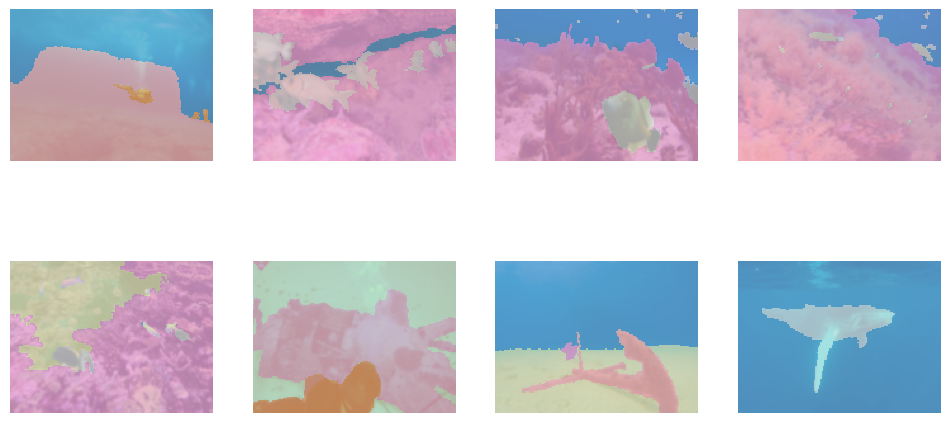

In [9]:
# image et mask superposé du train dataset
dls.show_batch(alpha = 0.5)
#show_at(dls.train_ds, 0, alpha = 0.5)  pour une image particulière

In [10]:
xb, yb = dls.train.one_batch()
print(f'xb: {xb.shape}, yb: {yb.shape}')
# En entrée du modèle: 8 images de couleur de format 160*120.
# le vecteur dépendant  contient les masques. tenseur 2D contenant les 8 classes de 0 à 7
# batch_size = 8

xb: torch.Size([8, 3, 120, 160]), yb: torch.Size([8, 120, 160])


In [11]:
print(codes)

# label correspondant au classes
name2id = {v:k for k,v in enumerate(codes)}
print(name2id)

['background' 'human_diver' 'aquatic_plants' 'wreck_ruins'
 'robots_instruments' 'reefs_invertebrates' 'fish_vertebrates'
 'sand_sea_floor_rocks']
{'background': 0, 'human_diver': 1, 'aquatic_plants': 2, 'wreck_ruins': 3, 'robots_instruments': 4, 'reefs_invertebrates': 5, 'fish_vertebrates': 6, 'sand_sea_floor_rocks': 7}


In [15]:
# Pour une classification à 5 éléments comme dans l'article, les classes 0, 2 et 7 sont regroupées
[name2id['background'], name2id['aquatic_plants'], name2id['sand_sea_floor_rocks']]

[0, 2, 7]

In [16]:
lbl_list = [name2id['human_diver'], name2id['wreck_ruins'],
            name2id['robots_instruments'], name2id['reefs_invertebrates'],
            name2id['fish_vertebrates']]
print(lbl_list)

[1, 3, 4, 5, 6]


In [12]:
dls.vocab = codes
dls.vocab

array(['background', 'human_diver', 'aquatic_plants', 'wreck_ruins',
       'robots_instruments', 'reefs_invertebrates', 'fish_vertebrates',
       'sand_sea_floor_rocks'], dtype='<U20')

#### Métriques
- precision_c = nombre de pixel correctement prédit pour la classe c / nombre de pixel prédit pour la classe c
- recall_c = nombre de pixel correctement prédit pour la classe c / nombre de pixel appartement à la classe c
- precision moyenne = somme (Precision_c) / # classes
- Intersection of Union IoU ou Jaccard score  (A inter B) / (A union B).  pour chaque classe

In [13]:
 # cette fonction calcul la précision moyenne: Nbre de pixel correctement prédit / nombre de pixel total

def acc_segment(input, target):
    """fonction pour calculer nombre de pixel correctement prédit/nombre de pixel total"""
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()   # argmax pour extraire la classe la plus probable
                                                          # la dim 1 du tensor contient les probabilités pour
                                                          # chaque classe
        
# cette fonction calcul la précision moyenne pour 5 classes restantes 
# HD, WR, RO, RI et FV.  le rest est considéré comme background
def acc_segment5(input, target):
    target = target.squeeze(1)               
    mask = (target != name2id['background'])\
    & (target != name2id['aquatic_plants'])\
    & (target != name2id['sand_sea_floor_rocks'])                        
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()  

def iou(input, target):
    """fonction pour calculer l'intersection over union moyenne sur les classes"""
    list_iou = []
    target = target.squeeze(1)
    for i in target.unique():
        mask_target = target == i                # True for the ith label class False elsewhere  for target y 
        mask_input = input.argmax(dim=1) == i    # True for the ith label class False elsewhere  for the pred y 
        inter = (mask_target*mask_input).sum()
        union = (mask_target + mask_input).sum()
        iou = inter.item()/union.item()
        list_iou.append(iou)
        
    return (tensor(list_iou).float().mean())

def iou5(input, target):
    """fonction pour calculer l'intersection over union moyenne sur les 5 classes"""
    list_iou = []
    target = target.squeeze(1)
    lbl = target.unique()                   # les labels existant dans un mask donné
    lbl_list = [name2id['human_diver'], name2id['wreck_ruins'],
            name2id['robots_instruments'], name2id['reefs_invertebrates'],
            name2id['fish_vertebrates']]
    lbl_keep = list(filter(lambda x: x in lbl_list, lbl))  # on garde seulement les 5 labels qui nous intéressent
    eps = 1e-5
    for i in lbl_keep:                           # on calcule le IoU pour chaque classe
        
        mask_target = target == i                # True for the ith label class False elsewhere  for target y 
        mask_input = input.argmax(dim=1) == i    # True for the ith label class False elsewhere  for the pred y 
        inter = (mask_target*mask_input).sum()
        union = (mask_target + mask_input).sum()
        if (inter <= eps) or (union <= eps):
            iou = 0
        else:
            iou = inter.item()/union.item()
            list_iou.append(iou)
            
    return (tensor(list_iou).float().mean())

def f1_5(input, target):
    """fonction pour calculer le f1 score moyenné sur les classes"""

    list_f1 = []
    target = target.squeeze(1)
    lbl = target.unique()
    lbl_list = [name2id['human_diver'], name2id['wreck_ruins'],
                name2id['robots_instruments'], name2id['reefs_invertebrates'],
                name2id['fish_vertebrates']]
    lbl_keep = list(filter(lambda x: x in lbl_list, lbl))
    eps = 1e-5
    for i in lbl_keep:
        mask_target = target == i                  # True for the ith label class False elsewhere  for target y 
        mask_input = input.argmax(dim=1) == i      # True for the ith label class False elsewhere  for the pred y 
        TP = (mask_target*mask_input).sum()        # labels correctement prédits, TP
        TP_FP = (mask_input).sum()                    # labels prédits 
        TP_FN = (mask_target).sum()                   # labels appartenant à la bonne classe
        
        if TP <= eps:                              # si pas de TP, prec = rec = f1 = 0
            prec = eps
            rec = eps
        else:
            prec = TP.item()/ TP_FP.item()
            rec = TP.item()/  TP_FN.item()

            
        f1 = 2*prec*rec/(prec+rec)
        list_f1.append(f1)
    
    return (tensor(list_f1).float().mean())

In [14]:
jaccard_coeff = JaccardCoeff()
dice_multi = DiceMulti()

In [16]:
 # on definit le modèle , architecture basée sur resnet34 
learn = unet_learner(dls, resnet18, metrics=[acc_segment,acc_segment5,foreground_acc,iou,iou5, f1_5]).to_fp16()

In [18]:
#learn.summary()

SuggestedLRs(valley=0.0002290867705596611)

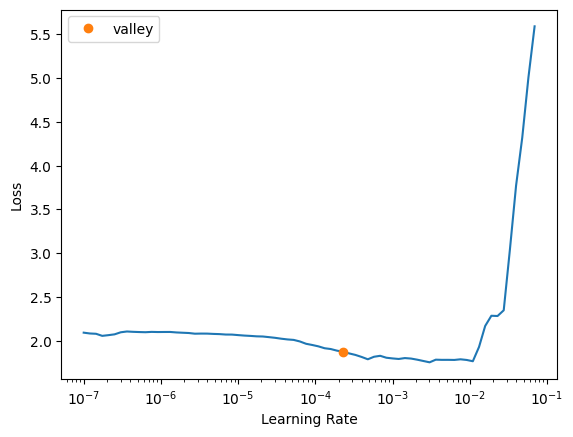

In [19]:
# fonction pour trouver un bon learning rate
learn.lr_find()

In [20]:
 # on entraine avec 12 epochs. Les métriques sont toujours calculés par défaut sur le validation set
wd = 1e-2
lr = 2e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.9, wd=wd)  

epoch,train_loss,valid_loss,acc_segment,acc_segment5,foreground_acc,iou,iou5,f1_5,time
0,1.403816,1.212042,0.603000,0.637356,0.507432,0.189797,0.198886,0.181608,01:16
1,1.157172,0.976347,0.687507,0.712910,0.601602,0.293289,0.369508,0.354807,01:16
2,1.040733,0.923612,0.707559,0.723154,0.615204,0.320889,0.375422,0.407314,01:17
3,0.981180,0.855074,0.729569,0.768903,0.661274,0.338074,0.439658,0.407335,01:20
4,0.942799,0.805190,0.738746,0.737070,0.655954,0.388586,0.451377,0.511804,01:33
5,0.945622,0.777918,0.749151,0.790734,0.722740,0.426228,0.494772,0.562253,01:17
6,0.945424,0.819203,0.747430,0.752940,0.690192,0.406814,0.449182,0.517745,01:17
7,0.842287,0.739775,0.767542,0.780157,0.704885,0.444771,0.520678,0.582262,01:16
8,0.880803,0.751328,0.763422,0.769925,0.692067,0.433849,0.512759,0.571821,01:16
9,0.742138,0.715677,0.773474,0.789805,0.715151,0.462047,0.549931,0.605696,01:16


In [21]:
 # on sauvegarde le modèle et ses poids
learn.save('res18_stage1_segmentation')

Path('models/res18_stage1_segmentation.pth')

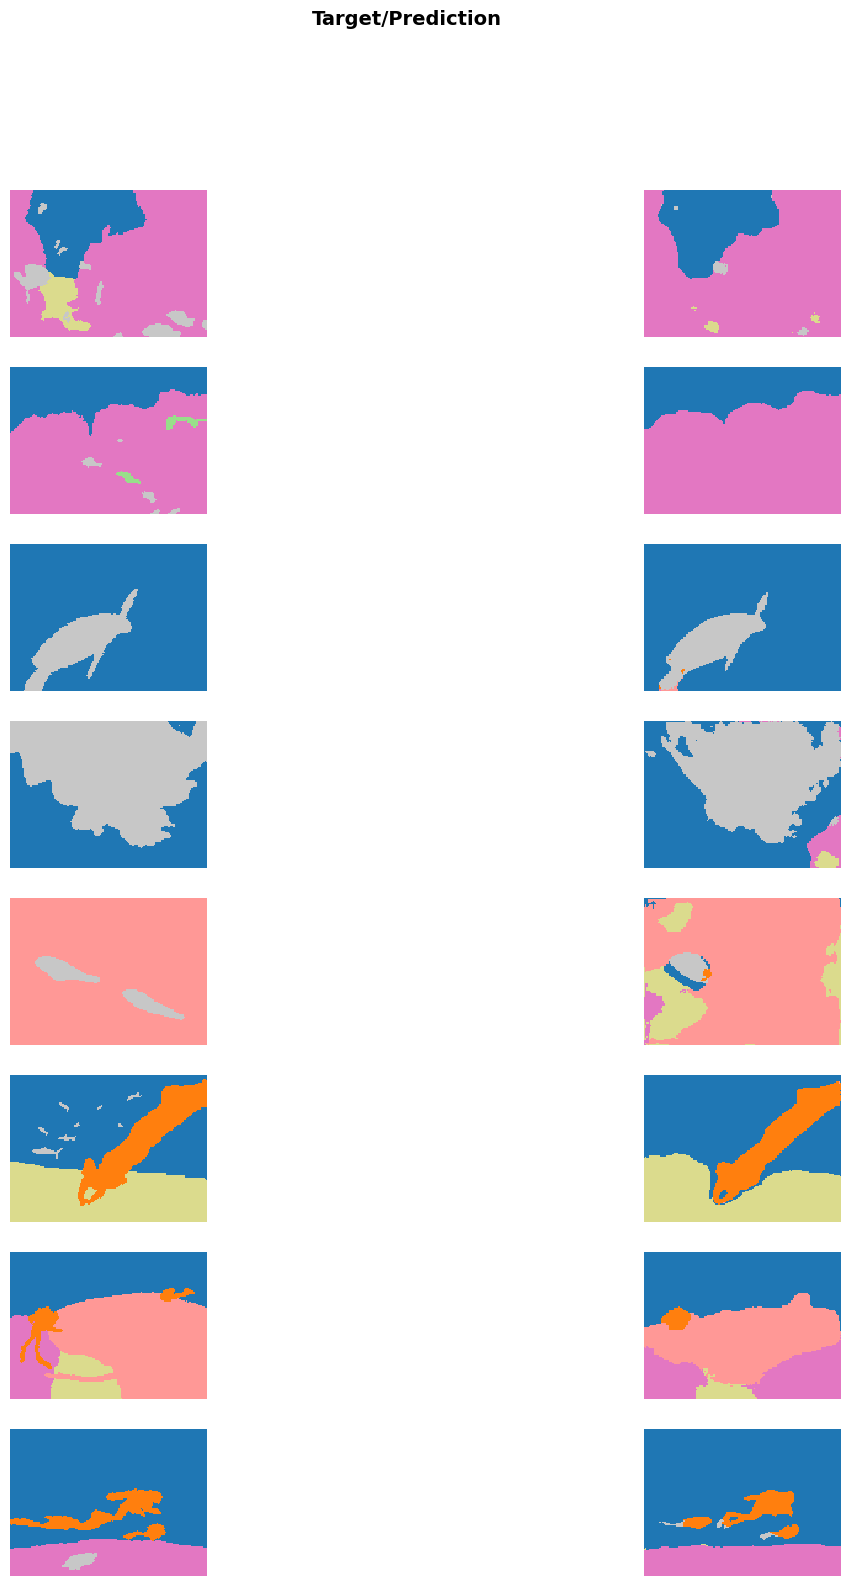

In [25]:
learn.show_results(ds_idx=0,max_n=8,figsize=(15,18), alpha = 1, shuffle = False)